In [1]:
from awpy import Demo

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import load, dump
import random
import json
import sys
import os

pd.set_option('display.max_columns', 100)
sys.path.append(os.path.abspath('./package'))

from CS2.graph import TabularSnapshots, GraphSnapshots
from CS2.token import Tokenizer
from CS2.preprocess import NormalizerDictionary, NormalizeMap

### ***awpy2*** test

In [11]:
dem = Demo(path='../../data/matches-raw/cs2/2024/_blast-premier-spring-final-2024-faze-vs-vitality-bo3-lQLvdLlJcL7dI4fNDLSZOXfaze-vs-vitality-m1-inferno.dem')

In [17]:
dem.damages

,tick,weapon,dmg_armor,dmg_health,hitgroup,is_bomb_planted,attacker_X,attacker_Y,attacker_Z,attacker_pitch,attacker_yaw,attacker_last_place_name,attacker_health,attacker_armor_value,attacker_current_equip_value,attacker_has_defuser,attacker_has_helmet,attacker_inventory,attacker_ping,attacker_team_name,attacker_team_clan_name,attacker_name,attacker_steamid,victim_X,victim_Y,victim_Z,victim_pitch,victim_yaw,victim_last_place_name,victim_health,victim_armor_value,victim_current_equip_value,victim_has_defuser,victim_has_helmet,victim_inventory,victim_ping,victim_team_name,victim_team_clan_name,victim_name,dmg_health_real,round
2,10272,p250,0,113,head,False,129.721252,739.149109,82.732506,-1.821671,-14.330627,Middle,100.0,0.0,800.0,False,False,"[knife_butterfly, P250]",0.0,TERRORIST,FaZe Clan,karrigan,76561197989430253,1472.877319,394.993256,129.03125,2.298889,165.136536,TopofMid,100,100,850,False,False,"[knife_karambit, P2000]",0,CT,Vitality,mezii,100,1
3,11617,glock,0,101,head,False,1462.034790,726.579590,129.149948,-5.543976,102.331482,TopofMid,100.0,100.0,850.0,False,False,"[knife_m9_bayonet, Glock-18]",0.0,TERRORIST,FaZe Clan,rain,76561197997351207,1344.216064,1225.211060,181.03125,3.036011,-82.270775,TopofMid,100,0,600,True,False,"[knife_butterfly, USP-S]",0,CT,Vitality,flameZ,100,1
4,12061,hkp2000,0,32,chest,False,2224.749023,183.731079,141.387985,1.234253,-150.865631,BombsiteA,100.0,100.0,850.0,False,False,"[knife_butterfly, USP-S]",0.0,CT,Vitality,Spinx,76561198063336407,1818.037476,-52.395081,135.24823,-1.385986,34.654663,BombsiteA,100,0,800,False,False,"[knife_butterfly, P250]",0,TERRORIST,FaZe Clan,karrigan,32,1
5,12085,hkp2000,0,128,head,False,2222.824707,174.403809,142.227005,0.677719,-151.857834,BombsiteA,100.0,100.0,850.0,False,False,"[knife_butterfly, USP-S]",0.0,CT,Vitality,Spinx,76561198063336407,1806.705322,-29.692566,132.03125,-0.316895,21.388672,BombsiteA,68,0,800,False,False,"[knife_butterfly, P250]",0,TERRORIST,FaZe Clan,karrigan,68,1
6,12153,glock,6,11,chest,False,1847.924194,-334.770996,261.031250,9.968719,58.244354,Apartments,100.0,100.0,850.0,False,False,"[knife_karambit, Glock-18]",0.0,TERRORIST,FaZe Clan,ropz,76561197991272318,2206.666504,244.622192,149.95137,-1.306686,90.385193,BombsiteA,100,100,850,False,False,"[knife_butterfly, USP-S]",0,CT,Vitality,Spinx,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,153453,ak47,3,28,chest,False,1310.254150,336.792114,129.531250,3.532791,-77.463913,Apartments,98.0,99.0,3750.0,False,False,"[knife_karambit, Glock-18, AK-47, Flashbang]",0.0,TERRORIST,Vitality,Spinx,76561198063336407,1405.185791,-86.859070,132.03125,12.694702,102.902405,Quad,18,71,5200,False,True,"[knife_karambit, USP-S, High Explosive Grenade...",0,CT,FaZe Clan,ropz,18,17
479,153453,m4a1,5,25,chest,False,1476.196045,1072.835693,160.052673,3.643005,-102.239456,TopofMid,100.0,94.0,5400.0,False,True,"[knife_m9_bayonet, USP-S, M4A1-S]",0.0,CT,FaZe Clan,rain,76561197997351207,1310.254150,336.792114,129.53125,3.532791,-77.463913,Apartments,98,99,3750,False,False,"[knife_karambit, Glock-18, AK-47, Flashbang]",0,TERRORIST,Vitality,Spinx,25,17
480,153472,m4a1,5,24,chest,False,1476.196045,1072.835693,160.052673,5.781555,-102.714615,TopofMid,100.0,94.0,5400.0,False,True,"[knife_m9_bayonet, USP-S, M4A1-S]",0.0,CT,FaZe Clan,rain,76561197997351207,1303.226074,335.238586,129.53125,9.365158,-77.294655,Apartments,73,94,3750,False,False,"[knife_karambit, Glock-18, AK-47, Flashbang]",0,TERRORIST,Vitality,Spinx,24,17
481,153485,m4a1,0,26,left leg,False,1476.196045,1072.835693,160.052673,9.820740,-103.308563,TopofMid,100.0,94.0,5400.0,False,True,"[knife_m9_bayonet, USP-S, M4A1-S]",0.0,CT,FaZe Clan,rain,76561197997351207,1299.054077,333.705963,129.53125,9.292374,-62.387238,Apartments,49,89,3750,False,False,"[knife_karambit, Glock-18, AK-47, Flashbang]",0,TERRORIST,Vitality,Spinx,26,17


In [33]:
dmg = dem.damages
dmg.loc[(dmg['round'] == 1) & (dmg['attacker_name'] == 'ropz')]['dmg_health_real'].sum()

161

In [49]:
# Create a groupby in the dataframe based on round and atacker to sum the damage dealt in each round
# In the final dataset, there shouild be 3 columns: round, attacker_name, and dmg_health_real
# and N rows, where N is the number of rounds in the match
def damage_dealt(dmg):
    dmg = dmg.groupby(['round', 'attacker_name'])['dmg_health_real'].sum().reset_index()
    dmg = dmg.rename(columns={'attacker_name': 'name', 'dmg_health_real': 'stat_damage'})
    dmg['round'] += 1
    return dmg

# Create a groupby in the dataframe based on round and atacker to sum the damage dealt in each round
tst = damage_dealt(dem.damages)
tst

,round,name,stat_damage
0,2,Spinx,115
1,2,ZywOo,100
2,2,apEX,285
3,2,karrigan,100
4,2,rain,135
...,...,...,...
124,18,frozen,203
125,18,karrigan,46
126,18,mezii,100
127,18,rain,126


In [3]:
dem = Demo(path='../../data/matches-raw/cs2/2024/_blast-premier-spring-groups-2024-g2-vs-natus-vincere-bo3-YNZzdluz2vLlZbsmgT1lX3g2-vs-natus-vincere-m2-inferno.dem')

### Graph creator test

In [2]:
# Map nodes dataset
nodes = pd.read_csv('../../data/map_graph_model/de_inferno/nodes.csv')
edges = pd.read_csv('../../data/map_graph_model/de_inferno/edges.csv')

# Create tabular snapshot object
tc = TabularSnapshots()

# Create tabular snapshot database
df, df_dict, active_infernos, active_smokes, active_he_smokes = tc.process_match(
    match_path='../../data/matches-raw/cs2/2024/_iem-chengdu-2024-wildcard-vs-virtuspro-inferno-norx8DdKJD9R1hFM8pob5fwildcard-vs-virtus-pro-inferno.dem',
    player_stats_data_path='../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv',
    missing_player_stats_data_path='../../data/player-stats/missing_players_df.csv',
    weapon_data_path='../../data/weapon_info/ammo_info.csv',

    ticks_per_second=4,
    numerical_match_id=1000,
    num_permutations_per_round=1,
    build_dictionary=True
)

# Impute missing values
df = tc.impute_match(df)

# Tokenize match
tokenizer = Tokenizer()
df = tokenizer.tokenize_match(df, 'de_inferno', nodes)

df.head(5)

,CT0_name,CT0_X,CT0_Y,CT0_Z,CT0_pitch,CT0_yaw,CT0_velocity_X,CT0_velocity_Y,CT0_velocity_Z,CT0_health,CT0_armor_value,CT0_active_weapon_magazine_size,CT0_active_weapon_ammo,CT0_active_weapon_magazine_ammo_left_%,CT0_active_weapon_max_ammo,CT0_total_ammo_left,CT0_active_weapon_total_ammo_left_%,CT0_flash_duration,CT0_balance,CT0_current_equip_value,CT0_round_start_equip_value,CT0_is_alive,CT0_is_CT,CT0_is_shooting,CT0_is_crouching,CT0_is_ducking,CT0_is_duck_jumping,CT0_is_walking,CT0_is_spotted,CT0_is_scoped,CT0_is_defusing,CT0_is_reloading,CT0_is_in_bombsite,CT0_stat_kills,CT0_stat_HS_kills,CT0_stat_opening_kills,CT0_stat_deaths,CT0_stat_opening_deaths,CT0_stat_assists,CT0_stat_flash_assists,CT0_stat_damage,CT0_stat_weapon_damage,CT0_stat_nade_damage,CT0_stat_survives,CT0_stat_KPR,CT0_stat_ADR,CT0_stat_DPR,CT0_stat_HS%,CT0_stat_SPR,CT0_inventory_C4,...,T9_hltv_saved_by_teammatePR,T9_hltv_saved_teammatesPR,T9_hltv_opening_kill_rating,T9_hltv_team_W%_after_opening,T9_hltv_opening_kill_in_W_rounds,T9_hltv_rating_1.0_all_Career,T9_hltv_clutches_1on1_ratio,T9_hltv_clutches_won_1on1,T9_hltv_clutches_won_1on2,T9_hltv_clutches_won_1on3,T9_hltv_clutches_won_1on4,T9_hltv_clutches_won_1on5,NUMERICAL_MATCH_ID,MATCH_ID,UNIVERSAL_tick,UNIVERSAL_round,UNIVERSAL_time,UNIVERSAL_remaining_time,UNIVERSAL_freeze_end,UNIVERSAL_end,UNIVERSAL_CT_wins,UNIVERSAL_CT_score,UNIVERSAL_T_score,UNIVERSAL_CT_alive_num,UNIVERSAL_T_alive_num,UNIVERSAL_CT_total_hp,UNIVERSAL_T_total_hp,UNIVERSAL_CT_equipment_value,UNIVERSAL_T_equipment_value,UNIVERSAL_CT_losing_streak,UNIVERSAL_T_losing_streak,UNIVERSAL_is_bomb_dropped,UNIVERSAL_is_bomb_being_planted,UNIVERSAL_is_bomb_being_defused,UNIVERSAL_is_bomb_defused,UNIVERSAL_is_bomb_planted_at_A_site,UNIVERSAL_is_bomb_planted_at_B_site,UNIVERSAL_bomb_X,UNIVERSAL_bomb_Y,UNIVERSAL_bomb_Z,UNIVERSAL_bomb_mx_pos1,UNIVERSAL_bomb_mx_pos2,UNIVERSAL_bomb_mx_pos3,UNIVERSAL_bomb_mx_pos4,UNIVERSAL_bomb_mx_pos5,UNIVERSAL_bomb_mx_pos6,UNIVERSAL_bomb_mx_pos7,UNIVERSAL_bomb_mx_pos8,UNIVERSAL_bomb_mx_pos9,TOKEN
0,fame,2353.000000,1977.000000,135.518890,6.993835,-95.568008,0.000000,0.000000,0.000000,100,100,0,0.0,0.0,0,1.0,0.0,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1263,1,115.00,115.00,1263,6403,1,0,0,5,5,500,500,4600,5000,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1000000000050000000000000000000000000000000000...
1,fame,2350.104736,1947.279297,135.539261,6.993835,-95.568008,-0.281738,-2.892334,0.001312,100,100,0,0.0,0.0,0,1.0,0.0,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1279,1,114.75,114.75,1263,6403,1,0,0,5,5,500,500,4600,5000,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1000000000050000000000000000000000000000000000...
2,fame,2344.702148,1890.890381,136.600327,6.630936,-94.624214,-0.351807,-3.798950,0.002365,100,100,0,0.0,0.0,0,1.0,0.0,0.0,150,850,200,True,1,True,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1295,1,114.50,114.50,1263,6403,1,0,0,5,5,500,500,4600,5000,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1000000000050000000000000000000000000000000000...
3,fame,2340.188232,1828.620605,139.374146,5.033447,-90.921822,-0.212891,-3.900391,0.021667,100,100,0,0.0,0.0,0,1.0,0.0,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,

In [3]:
# Build dictionary
dictionary = NormalizerDictionary().build_single_dictionary(df_dict)

# Get map normalization config file
inferno_norm_config = '../../config/game/map_normalization/inferno.json'
with open(inferno_norm_config, 'r') as f:
    CONFIG_INF_NORM = json.load(f)


# Normalize match
df = tc.noramlize_match(df, dictionary, CONFIG_INF_NORM)
df.head(5)

,CT0_name,CT0_X,CT0_Y,CT0_Z,CT0_pitch,CT0_yaw,CT0_velocity_X,CT0_velocity_Y,CT0_velocity_Z,CT0_health,CT0_armor_value,CT0_active_weapon_magazine_size,CT0_active_weapon_ammo,CT0_active_weapon_magazine_ammo_left_%,CT0_active_weapon_max_ammo,CT0_total_ammo_left,CT0_active_weapon_total_ammo_left_%,CT0_flash_duration,CT0_balance,CT0_current_equip_value,CT0_round_start_equip_value,CT0_is_alive,CT0_is_CT,CT0_is_shooting,CT0_is_crouching,CT0_is_ducking,CT0_is_duck_jumping,CT0_is_walking,CT0_is_spotted,CT0_is_scoped,CT0_is_defusing,CT0_is_reloading,CT0_is_in_bombsite,CT0_stat_kills,CT0_stat_HS_kills,CT0_stat_opening_kills,CT0_stat_deaths,CT0_stat_opening_deaths,CT0_stat_assists,CT0_stat_flash_assists,CT0_stat_damage,CT0_stat_weapon_damage,CT0_stat_nade_damage,CT0_stat_survives,CT0_stat_KPR,CT0_stat_ADR,CT0_stat_DPR,CT0_stat_HS%,CT0_stat_SPR,CT0_inventory_C4,...,T9_hltv_saved_by_teammatePR,T9_hltv_saved_teammatesPR,T9_hltv_opening_kill_rating,T9_hltv_team_W%_after_opening,T9_hltv_opening_kill_in_W_rounds,T9_hltv_rating_1.0_all_Career,T9_hltv_clutches_1on1_ratio,T9_hltv_clutches_won_1on1,T9_hltv_clutches_won_1on2,T9_hltv_clutches_won_1on3,T9_hltv_clutches_won_1on4,T9_hltv_clutches_won_1on5,NUMERICAL_MATCH_ID,MATCH_ID,UNIVERSAL_tick,UNIVERSAL_round,UNIVERSAL_time,UNIVERSAL_remaining_time,UNIVERSAL_freeze_end,UNIVERSAL_end,UNIVERSAL_CT_wins,UNIVERSAL_CT_score,UNIVERSAL_T_score,UNIVERSAL_CT_alive_num,UNIVERSAL_T_alive_num,UNIVERSAL_CT_total_hp,UNIVERSAL_T_total_hp,UNIVERSAL_CT_equipment_value,UNIVERSAL_T_equipment_value,UNIVERSAL_CT_losing_streak,UNIVERSAL_T_losing_streak,UNIVERSAL_is_bomb_dropped,UNIVERSAL_is_bomb_being_planted,UNIVERSAL_is_bomb_being_defused,UNIVERSAL_is_bomb_defused,UNIVERSAL_is_bomb_planted_at_A_site,UNIVERSAL_is_bomb_planted_at_B_site,UNIVERSAL_bomb_X,UNIVERSAL_bomb_Y,UNIVERSAL_bomb_Z,UNIVERSAL_bomb_mx_pos1,UNIVERSAL_bomb_mx_pos2,UNIVERSAL_bomb_mx_pos3,UNIVERSAL_bomb_mx_pos4,UNIVERSAL_bomb_mx_pos5,UNIVERSAL_bomb_mx_pos6,UNIVERSAL_bomb_mx_pos7,UNIVERSAL_bomb_mx_pos8,UNIVERSAL_bomb_mx_pos9,TOKEN
0,fame,0.963250,0.619250,0.033880,0.479426,0.234506,0.519795,0.505849,0.554759,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,0.009375,0.082803,0.0,True,1,False,0,0,0,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1263,0.041667,1.000000,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.144427,0.189394,0.2,0.2,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1000000000050000000000000000000000000000000000...
1,fame,0.962526,0.611820,0.033885,0.479426,0.234506,0.487757,0.170550,0.554796,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,0.009375,0.082803,0.0,True,1,False,0,0,0,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1279,0.041667,0.998155,0.997913,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.144427,0.189394,0.2,0.2,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1000000000050000000000000000000000000000000000...
2,fame,0.961176,0.597723,0.034150,0.477123,0.237128,0.479789,0.065449,0.554827,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,0.009375,0.082803,0.0,True,1,True,0,0,0,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,1.0,0,...,0.555556,0.611111,0.54321,0.857,0.444444,0.571429,1.0,0.064103,0.133333,0.153846,0.0,0.0,1000,../../data/matches-raw/cs2/2024/_iem-chengdu-2...,1295,0.041667,0.996310,0.995826,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.144427,0.189394,0.2,0.2,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1000000000050000000000000000000000000000000000...
3,fame,0.960047,0.582155,0.034844,0.466982,0.247413,0.495586,0.053690,0.555382,1.0,1.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.0,0.009375,0.082803,0.0,True

In [8]:
# Read normalized map
nodes_norm = pd.read_csv('../../data/map_graph_model/de_inferno/nodes_norm.csv')

# Graph snapshots
gs = GraphSnapshots()
graphs = gs.process_snapshots(df, nodes, edges, active_infernos, active_smokes, active_he_smokes)

# --------------------------------------------------
# TODO: Add the smokes to the map graph
# --------------------------------------------------

1263
1279
1295
1311
1327
1343
1359
1375
1391
1407
1423
1439
1455
1471
1487
1503
1519
1535
1551
1567
1583
1599
1615
1631
1647
1663
1679
1695
1711
1727
1743
1759
1775
1791
1807
1823
1839
1855
1871
1887
1903
1919
1935
1951
1967
1983
1999
2015
2031
2047
2063
2079
2095
2111
2127
2143
2159
2175
2191
2207
2223
2239
2255
2271
2287
2303
2319
2335
2351
2367
2383
2399
2415
2431
2447
2463
2479
2495
2511
2527
2543
2559
2575
2591
2607
2623
2639
2655
2671
2687
2703
2719
2735
2751
2767
2783
2799
2815
2831
2847
2863
2879
2895
2911
2927
2943
2959
2975
2991
3007
3023
3039
3055
3071
3087
3103
3119
3135
3151
3167
3183
3199
3215
3231
3247
3263
3279
3295
3311
3327
3343
3359
3375
3391
3407
3423
3439
3455
3471
3487
3503
3519
3535
3551
3567
3583
3599
3615
3631
3647
3663
3679
3695
3711
3727
3743
3759
3775
3791
3807
3823
3839
3854
3870
3886
3902
3918
3934
3950
3966
3982
3998
4014
4030
4046
4062
4078
4094
4110
4126
4142
4158
4174
4190
4206
4222
4238
4254
4270
4286
4302
4318
4334
4350
4366
4382
4398
4414
4430
4446


In [5]:
for idx in range(0,len(graphs)):
    if (graphs[idx]['map'].x[:, -1].sum() != 0):
        print(idx)

In [9]:
graph_to_plot = graphs[2600]

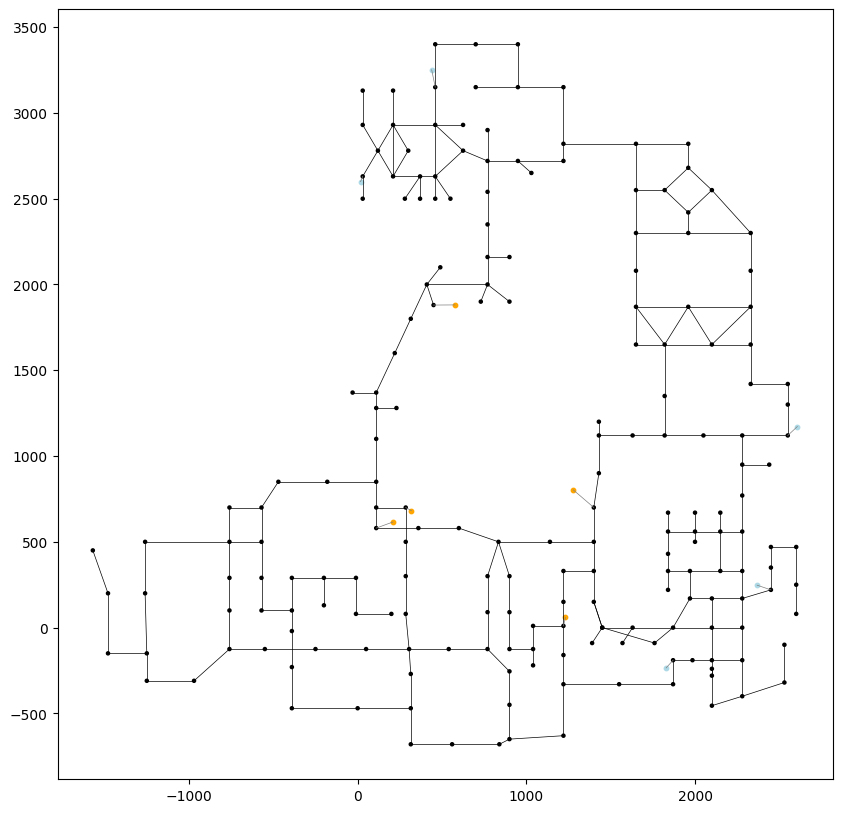

In [10]:
map_nodes = graph_to_plot['map'].x[:, 1:4].numpy()
map_edges = graph_to_plot['map', 'connected_to', 'map'].edge_index.numpy()
players = graph_to_plot['player'].x[:, 0:3].numpy()
player_edges = graph_to_plot['player', 'closest_to', 'map'].edge_index.numpy()

fig, ax = plt.subplots(figsize=(10, 10))

# Map
plt.scatter(map_nodes[:, 0], map_nodes[:, 1], s=5, c=graph_to_plot['map'].x[:, -1], cmap='copper')

for edge in map_edges.T:
    plt.plot(map_nodes[edge, 0], map_nodes[edge, 1], c='black', linewidth=0.5)

# Players
plt.scatter(players[:5, 0], players[:5, 1], s=10, c='lightblue')
plt.scatter(players[5:, 0], players[5:, 1], s=10, c='orange')

for edge in player_edges.T:
    plt.plot([players[edge[0]][0], map_nodes[edge[1]][0]], [players[edge[0]][1], map_nodes[edge[1]][1]], c='grey', linewidth=0.5)